# Selecting best Random Forest Model

- Read all feature sets
- apply random forest, on base feature set to get the base model
- apply random forest, for rest of the feature sets
- observe the results
- apply grid search to improve on the results

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
import joblib

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

**reading all the feature set files**

In [19]:
# base feature set
df_base = pd.read_csv('input/feature_sets/base.csv')

# base feature set with advanced features
df_base_adv = pd.read_csv('input/feature_sets/base_adv.csv')

# base feature set with dimensionality reduction
df_base_filtered = pd.read_csv('input/feature_sets/base_filtered.csv')

# base feature set with advance features and dimensionality reduction
df_base_adv_filtered = pd.read_csv('input/feature_sets/base_adv_filtered.csv')

# base feature set with mean features
df_base_mean = pd.read_csv('input/feature_sets/base_mean.csv')

# base feature set with advanced and mean encoded features
df_base_adv_mean = pd.read_csv('input/feature_sets/base_adv_mean.csv')

# 1. Model With Base Features

**applying train test split on base features**

In [20]:
X = df_base.drop(['status_group','id'], axis=1)
y = df_base['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39798 entries, 107 to 56422
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   district_code            39798 non-null  int64  
 1   basin                    39798 non-null  int64  
 2   region                   39798 non-null  int64  
 3   region_code              39798 non-null  int64  
 4   public_meeting_label     39798 non-null  int64  
 5   scheme_management_label  39798 non-null  int64  
 6   permit_label             39798 non-null  int64  
 7   extraction_type_group    39798 non-null  int64  
 8   extraction_type_class    39798 non-null  int64  
 9   extraction_type          39798 non-null  int64  
 10  management               39798 non-null  int64  
 11  management_group         39798 non-null  int64  
 12  payment                  39798 non-null  int64  
 13  payment_type             39798 non-null  int64  
 14  water_quality       

**creating the base model**

In [22]:
# get the rf object
rf_base = RandomForestClassifier(n_estimators=101, n_jobs=-1)

# fit the data
rf_clf = rf_base.fit(X_train,y_train)

**prediction**

In [23]:
rf_base_pred = rf_base.predict(X_test)

**confusion matrix**

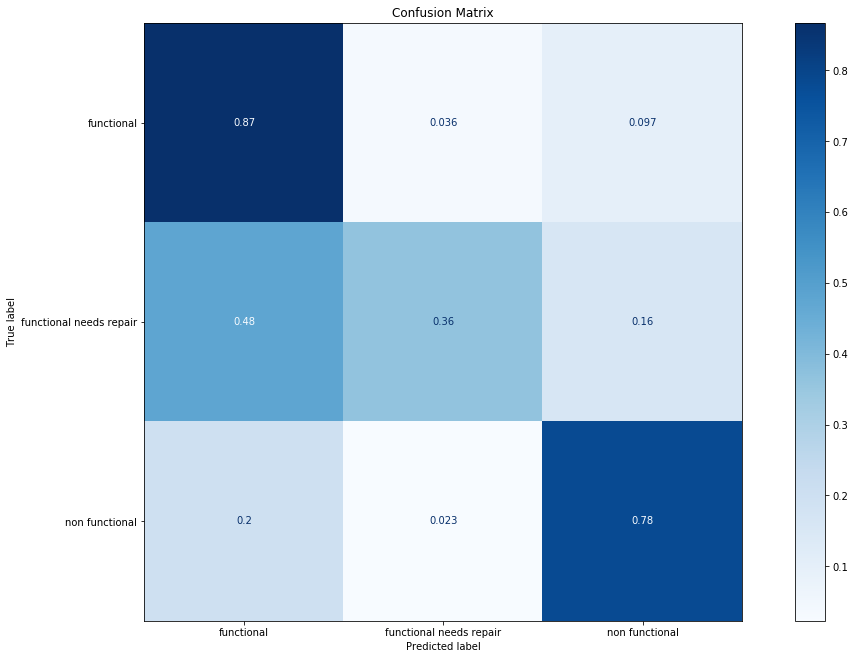

In [32]:
# Generate confusion matrix
fig, axes = plt.subplots(figsize=(19,11))

matrix = plot_confusion_matrix(rf_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax= axes)

plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

**accuracy score**

In [10]:
print(classification_report(y_test, rf_base_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.86      0.84     10719
functional needs repair       0.48      0.36      0.41      1425
         non functional       0.82      0.78      0.80      7458

               accuracy                           0.80     19602
              macro avg       0.70      0.67      0.68     19602
           weighted avg       0.79      0.80      0.79     19602



# 2. Model with Advanced Features

In [40]:
X = df_base_adv.drop(['status_group','id'], axis=1)
y = df_base_adv['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf_base_adv = RandomForestClassifier(n_estimators=101, n_jobs=-1)
rf_clf = rf_base_adv.fit(X_train, y_train)
rf_base_adv_pred = rf_base_adv.predict(X_test)

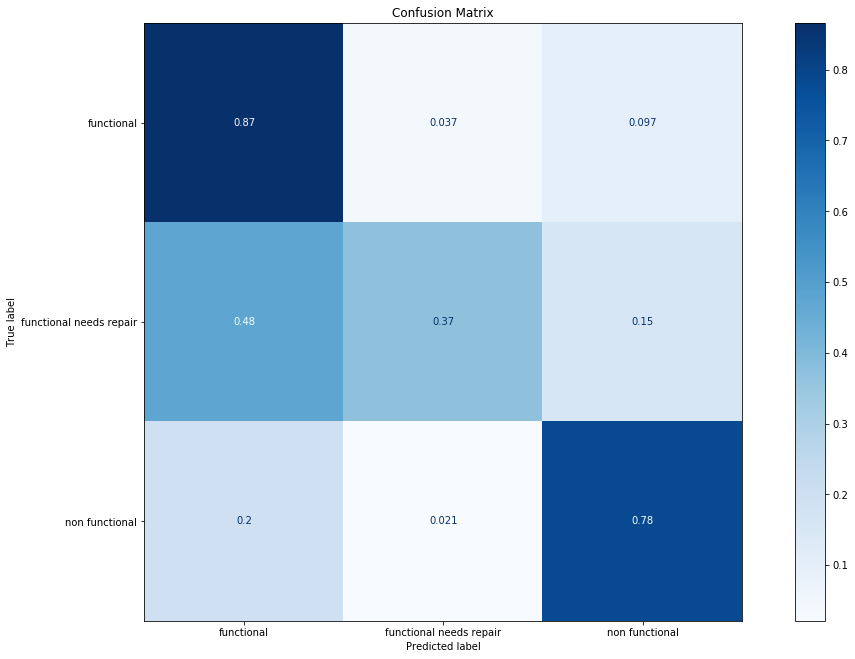

In [41]:
# Generate confusion matrix
fig, axes = plt.subplots(figsize=(19,11))

matrix = plot_confusion_matrix(rf_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax= axes)

plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

In [39]:
print(classification_report(y_test, rf_base_adv_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84     10719
functional needs repair       0.49      0.37      0.42      1425
         non functional       0.82      0.78      0.80      7458

               accuracy                           0.80     19602
              macro avg       0.71      0.67      0.69     19602
           weighted avg       0.79      0.80      0.79     19602



# 3. Model With Base Features with Filtered attributes

features that were removed after dimensionality reduction

In [42]:
X = df_base_adv_filtered.drop(['status_group','id','installer','scheme_name','quantity_group'], axis=1)
y = df_base_adv_filtered['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rf_base_adv_filtered = RandomForestClassifier(n_estimators=101, n_jobs=-1)
rf_clf = rf_base_adv_filtered.fit(X_train, y_train)
rf_base_adv_filtered_pred = rf_base_adv_filtered.predict(X_test)

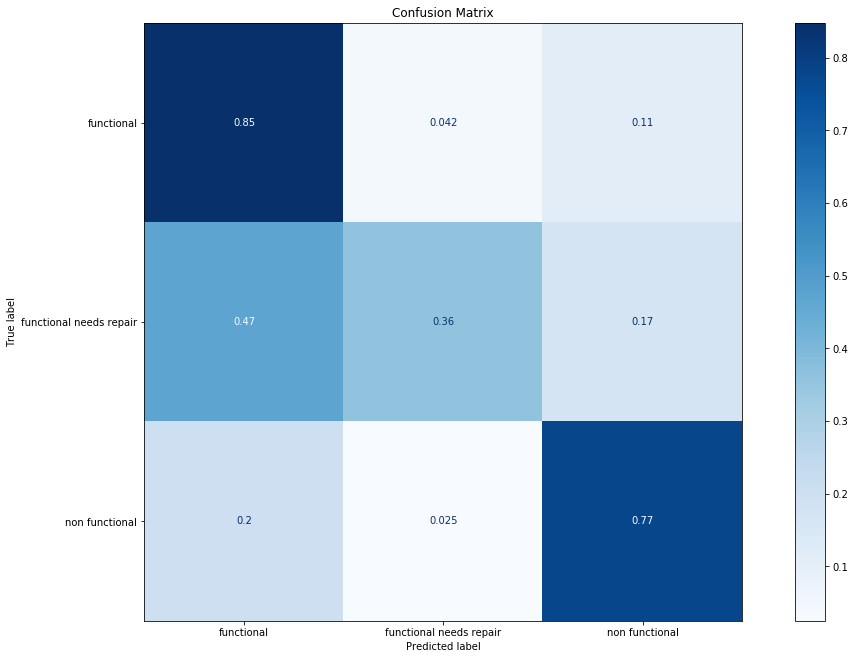

In [43]:
# Generate confusion matrix
fig, axes = plt.subplots(figsize=(19,11))

matrix = plot_confusion_matrix(rf_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax= axes)

plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

In [44]:
print(classification_report(y_test, rf_base_adv_filtered_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83     10719
functional needs repair       0.44      0.36      0.40      1425
         non functional       0.80      0.77      0.79      7458

               accuracy                           0.78     19602
              macro avg       0.68      0.66      0.67     19602
           weighted avg       0.78      0.78      0.78     19602



# 4. Model with Base Advanced Mean Features

In [45]:
X = df_base_adv_mean.drop(['status_group','id','functional needs repair','non functional'], axis=1)
y = df_base_adv_mean['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [47]:
rf_gs_best_1 = RandomForestClassifier(n_estimators=451, 
                                    n_jobs=-1, 
                                    bootstrap=False,
                                    criterion='entropy',
                                    max_depth=21,
                                    min_samples_split=5,
                                    min_samples_leaf=3
                                   )

In [48]:
rf_clf = rf_gs_best_1.fit(X_train, y_train)
rf_gs_best_mean_pred_1 = rf_gs_best_1.predict(X_test)

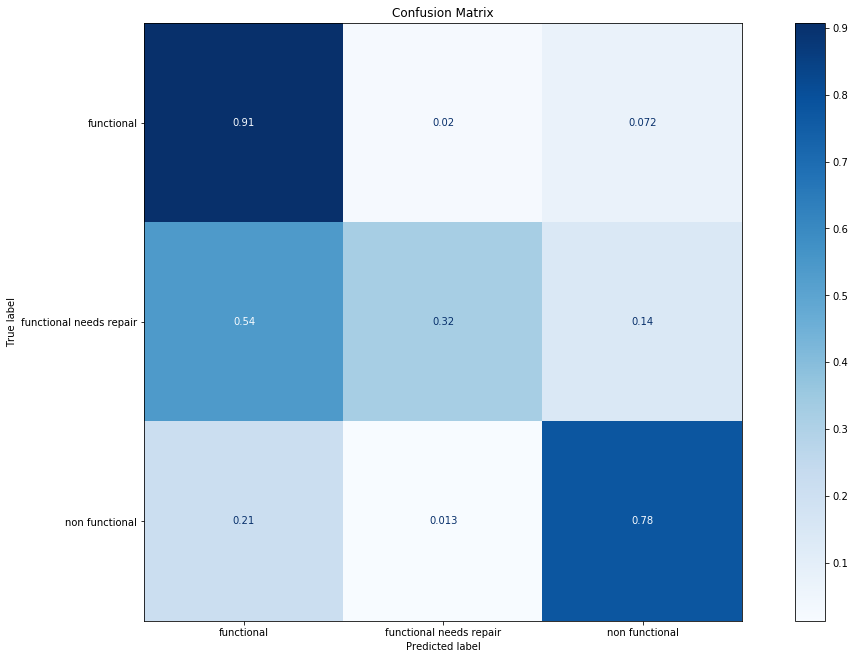

In [49]:
# Generate confusion matrix
fig, axes = plt.subplots(figsize=(19,11))

matrix = plot_confusion_matrix(rf_clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax= axes)

plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

In [51]:
print(classification_report(y_test, rf_gs_best_mean_pred_1))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6790
functional needs repair       0.59      0.32      0.42       885
         non functional       0.86      0.78      0.81      4799

               accuracy                           0.82     12474
              macro avg       0.75      0.67      0.69     12474
           weighted avg       0.81      0.82      0.81     12474



### This is the best model so far

# Creating Submission on the Best RF

In [53]:
# reading the file
features_to_drop = ['status_group','id']
df_test_X = pd.read_csv('input/feature_sets/base_adv_mean_test.csv')

# a little adjustment
df_test_X.funder_mean_nf.fillna(0, inplace=True) 
df_test_X.funder_mean_fr.fillna(0, inplace=True) 

# prediction
rf_gs_best_mean_sub_1 = rf_gs_best_1.predict(df_test_X.drop(features_to_drop, axis=1))

# preparing the file
df_test_X['status_group'] = rf_gs_best_mean_sub_1
df_gs_best_mean_sub_2 = df_test_X[['id','status_group']]

#saving the file
df_gs_best_mean_sub_2.to_csv('submissions/df_gs_best_mean_sub.csv', index=False)
del df_gs_best_mean_sub_2